# Chapter 4 Data preprocessing
## 4.1 Know your data

In [3]:
# Standard Library Imports
import os
import sys
from pathlib import Path
import warnings

# Add parent directory to path to import utils module (if necessary)
parent_dir = str(Path.cwd().parent)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Third-Party Imports
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from fredapi import Fred

# Local Imports
from utils import uniformize_data

In [ ]:
# --- Setup and Configuration ---

# Load environment variables
dotenv_path = Path.cwd().parent / '.env'
load_dotenv(dotenv_path)

# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


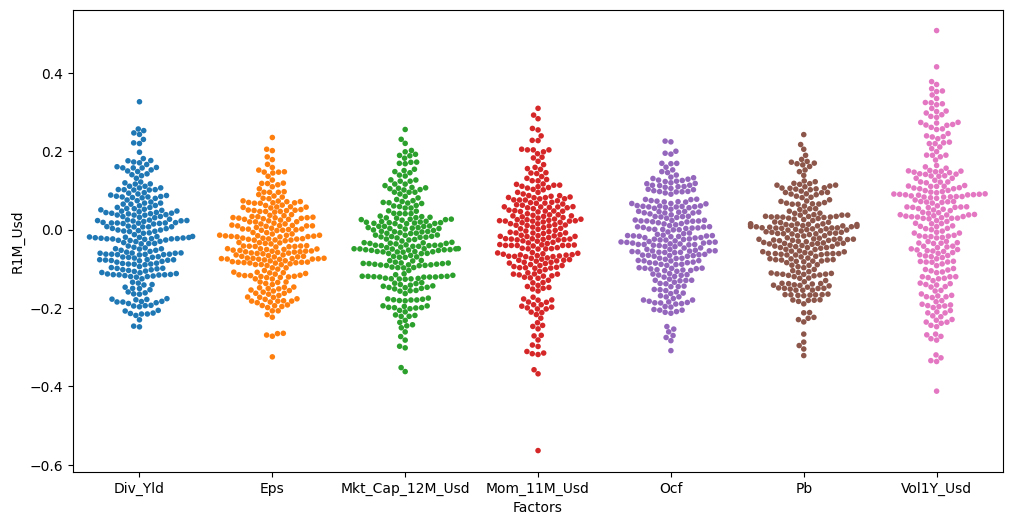

In [86]:
features=list(data_ml.iloc[:,3:95].columns) # Keep the features' column names
features_short =["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

cols= features_short+['R1M_Usd','date'] # Keep few features, label & dates
data_corr = data_ml[cols]               # Creating the working dataset
data_corr = data_corr.groupby('date').corr()[['R1M_Usd']].reset_index() # Group for computing correlation
data_corr= data_corr.loc[data_corr[data_corr.level_1.str[-7:] != "R1M_Usd"].index] # removing correl=1 instances from label
data_corr.rename(columns={'level_1': "Factors"},inplace=True) # Renaming for plotting later
plt.figure(figsize=(12,6))              # resizing the chart
sns.swarmplot(x="Factors", y="R1M_Usd", data=data_corr, size=4, hue="Factors", legend=False);

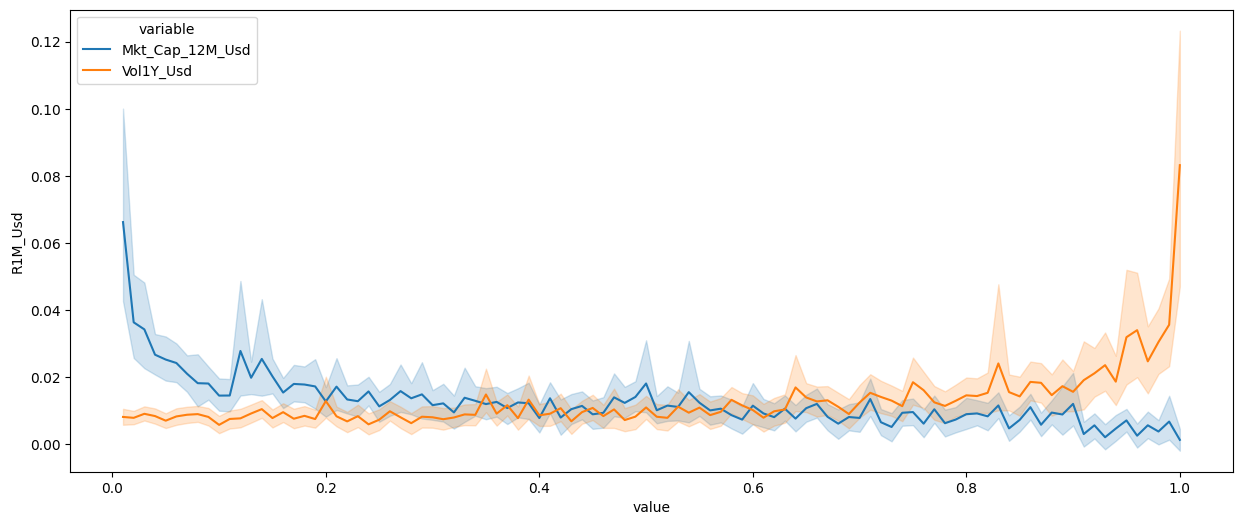

In [87]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
plt.figure(figsize=(15,6))
sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

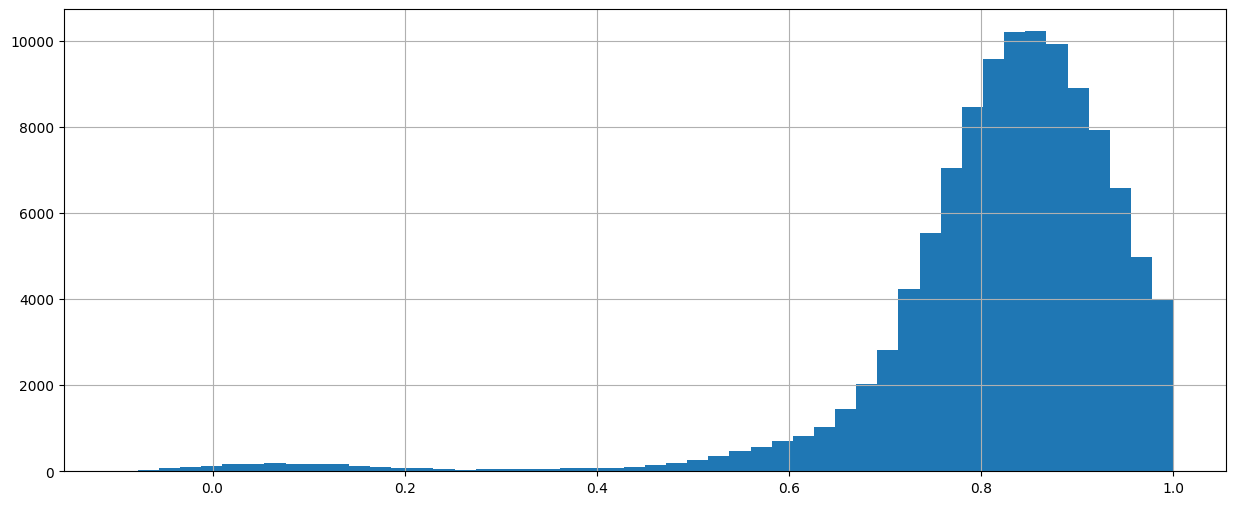

In [88]:
cols=[]                                 # cleaning the column list from previous use
cols = ['stock_id'] + list(data_ml.iloc[:,3:95].columns) # Keep all features and stockid

# Compute autocorrelation, filtering out invalid values
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    data_hist_acf = pd.melt(data_ml[cols], id_vars='stock_id').groupby(['stock_id','variable'], group_keys=False).apply(
        lambda x: x['value'].autocorr(lag=1), include_groups=False
    )

# Remove NaN and inf values before plotting
data_hist_acf = data_hist_acf.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(15,6))
data_hist_acf.hist(bins=50, range=[-0.1,1]); # Plot from pandas

## 4.8 Additional code and results
### 4.8.1 Impact of rescaling: graphical representation

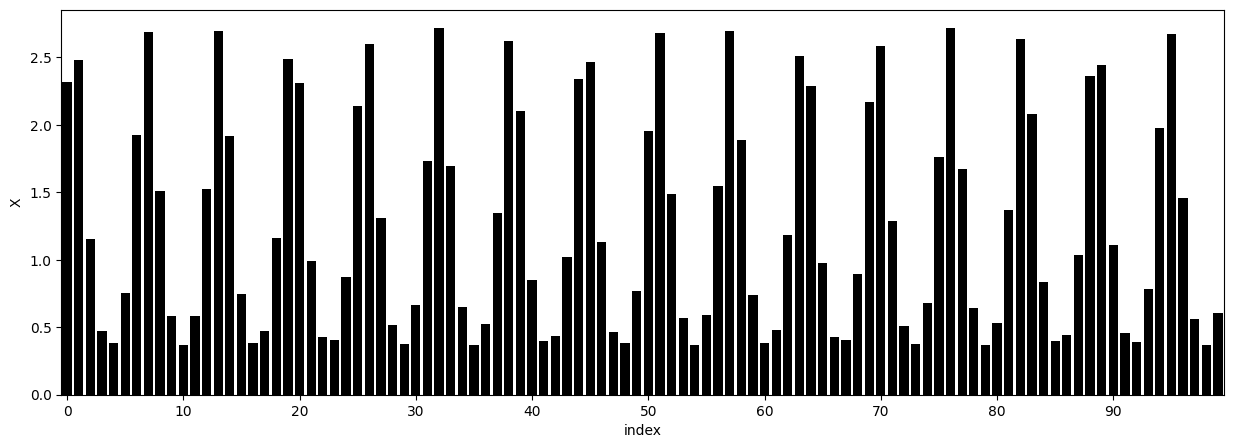

In [89]:
length = 100
x = np.exp(np.sin(np.linspace(1,length,length)))
data = pd.DataFrame(data=x,columns=['X'])
data.reset_index(inplace=True)
plt.figure(figsize=(15,5)) # resizing figure
sns.barplot(y="X", data=data, x="index", color='black'); # Plot from Seaborn
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

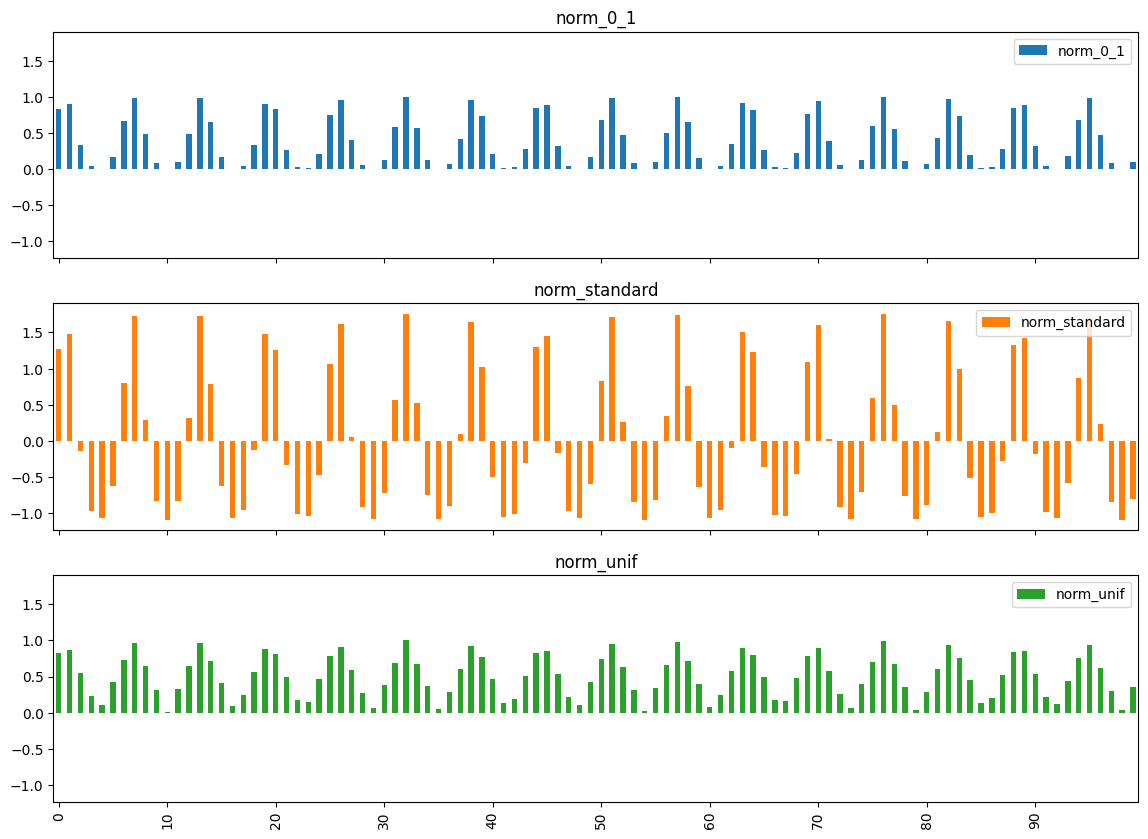

In [90]:
def norm_0_1(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
def norm_unif(x):
    return (ECDF(x)(x))
def norm_standard(x):
    return (x- np.mean(x))/np.std(x)

data_norm=pd.DataFrame.from_dict(dict( # ensembling numpy arrays into a dict and then a pd dataframe
index=np.linspace(1,length,length), # creating the index
norm_0_1=norm_0_1(x), # normalisation [0,1]
norm_standard=norm_standard(x), # standardisation
norm_unif=norm_unif(x))) # Uniformisation
data_norm.iloc[:,1:4].plot.bar( figsize=(14,10), subplots=True, sharey=True, sharex=True); # Plot
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

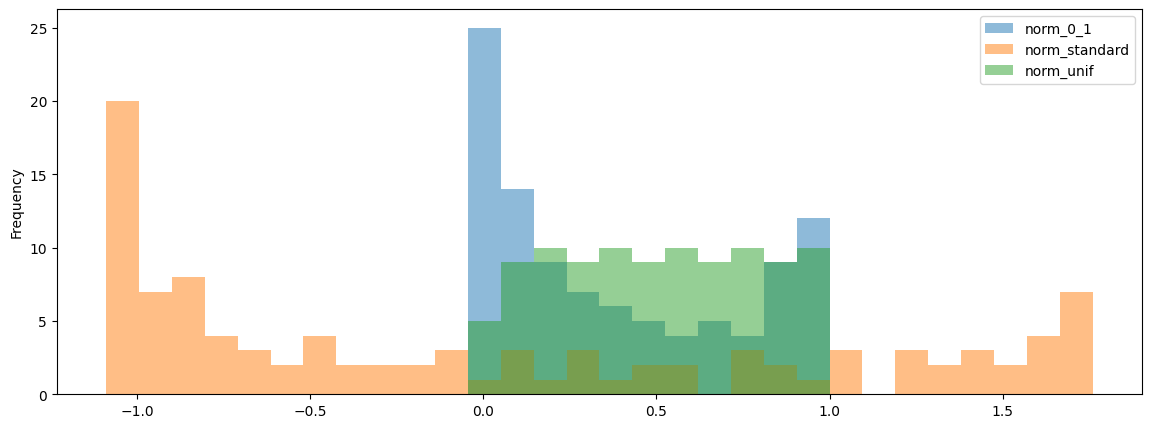

In [91]:
data_norm.iloc[:,1:4].plot.hist(alpha=0.5, bins=30, figsize=(14,5)); # Plot from pandas, alphas=opacity

### 4.8.2 Impact of rescaling: toy example

In [92]:
cap=np.array([10,50,100, # Market capitalization
              15,10,15,
              200,120,80])
returns=np.array([0.06,0.01,-0.06, # Return values
        -0.03,0.00,0.02,
        -0.04,-0.02,0.00])
date=np.array([1,2,3,1,2,3,1,2,3]) # Dates
firm=np.array([1,1,1,2,2,2,3,3,3]) # Firms (3 lines for each)
toy_data=pd.DataFrame.from_dict(dict(firm=firm,date=date,cap=cap,returns=returns, # Aggregation of data
cap_norm=norm_0_1(cap),
cap_u=norm_unif(cap))) 
toy_data

,firm,date,cap,returns,cap_norm,cap_u
0,1,1,10,0.06,0.000000,0.222222
1,1,2,50,0.01,0.210526,0.555556
2,1,3,100,-0.06,0.473684,0.777778
3,2,1,15,-0.03,0.026316,0.444444
4,2,2,10,0.00,0.000000,0.222222
5,2,3,15,0.02,0.026316,0.444444
6,3,1,200,-0.04,1.000000,1.000000
7,3,2,120,-0.02,0.578947,0.888889
8,3,3,80,0.00,0.368421,0.666667


In [93]:
X=toy_data.cap_norm.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     4.265
Date:                Wed, 03 Dec 2025   Prob (F-statistic):             0.0778
Time:                        15:38:06   Log-Likelihood:                 19.892
No. Observations:                   9   AIC:                            -35.78
Df Residuals:                       7   BIC:                            -35.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0124      0.014      0.912      0.392      -0.020       0.045
x1            -0.0641      0.031     -2.065      0.078      -0.137       0.009
==============================================================================
Omnibus:                        0.200   Durbin-Watson:                   0.872
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.152
Skew:                          -0.187   Prob(JB):                        0.927
Kurtosis:                       2.485   Cond. No.                         3.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
X=toy_data.cap_u.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     6.672
Date:                Wed, 03 Dec 2025   Prob (F-statistic):             0.0363
Time:                        15:38:06   Log-Likelihood:                 20.764
No. Observations:                   9   AIC:                            -37.53
Df Residuals:                       7   BIC:                            -37.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0457      0.022      2.056      0.079      -0.007       0.098
x1            -0.0902      0.035     -2.583      0.036      -0.173      -0.008
==============================================================================
Omnibus:                        1.603   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.449   Jarque-Bera (JB):                0.895
Skew:                          -0.428   Prob(JB):                        0.639
Kurtosis:                       1.715   Cond. No.                         5.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.9 Coding exercices

        date  stock_id  Cyclical_Capex
0 2006-12-31        13        0.817714
1 2007-01-31        13        0.162857
2 2007-02-28        13        0.797143
3 2015-03-31        17        0.140449
4 2015-04-30        17        0.064939


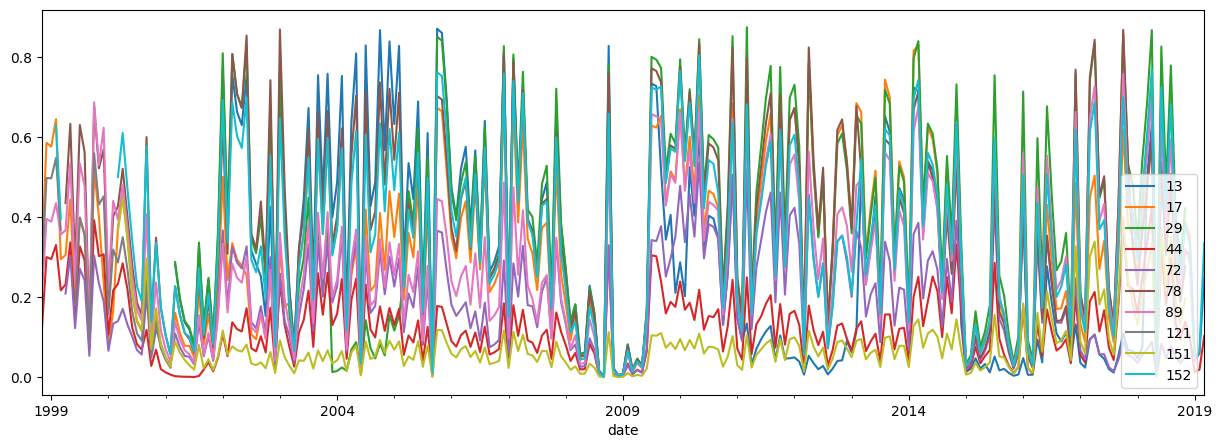

In [5]:
# 1. The Federal Reserve of Saint Louis (https://fred.stlouisfed.org) hosts thousands of time series of economic indicators that can serve as conditioning variables.
#    Pick one and apply formula (4.3) to expand the number of predictors. If need be, use the function defined above.

# --- LOADING AND PREPARING THE DATA ---
# Getting IP Index from FRED
FRED_API_KEY = os.environ.get("FRED_API_KEY")
fred = Fred(api_key=FRED_API_KEY)
ip_index_id = 'INDPRO'  # Industrial Production Index

start_date = (data_ml['date'].min() - DateOffset(months=1)).strftime('%Y-%m-%d')
end_date = data_ml['date'].max().strftime('%Y-%m-%d')

ip_index_serie = fred.get_series(
    ip_index_id, 
    observation_start=start_date, 
    observation_end=end_date
)

# Transform data (diff and uniformization)
ip_index_diff = ip_index_serie.diff()

ip_index_diff_uniformized = uniformize_data(ip_index_diff.dropna())
ip_index_final = ip_index_diff.copy()
ip_index_final.iloc[1:] = ip_index_diff_uniformized
ip_index_final = ip_index_final.dropna()


# --- MERGING DATAFRAMES ---
# Preparing IP index dataframe
ip_index_df = ip_index_final.to_frame().reset_index()
ip_index_df.columns = ['date', 'Ip_Index']
ip_index_df['date'] = pd.to_datetime(ip_index_df['date']).dt.to_period('M')

# Temporary period key (Year Month)
data_ml['date_period'] = data_ml['date'].dt.to_period('M')

# Merge dataframes
data_ml = data_ml.merge(
    ip_index_df,
    left_on='date_period',
    right_on = 'date',
    how='left'
)

# Clean up temporary and duplicates columns
data_ml.drop(columns=['date_period', 'date_y'], inplace=True)
data_ml.rename(columns={'date_x': 'date'}, inplace=True)


# --- FEATURES EXTENSION ---
data_ml['Cyclical_Capex'] = data_ml['Ip_Index'] * data_ml['Capex_Sales']


# --- DATA VISUALIZATION ---
# Table head of new feature
print(data_ml[['date', 'stock_id', 'Cyclical_Capex']].head())

# Plot (sample of stocks)
SAMPLE_STOCKS_NUMBER = 10
stocks_sample = data_ml['stock_id'].unique()[:SAMPLE_STOCKS_NUMBER]
cyclical_capex = data_ml.pivot(index='date', columns='stock_id', values='Cyclical_Capex')
cyclical_capex[stocks_sample].plot(figsize=(15,5), legend=False)
plt.legend(loc='lower right')
plt.show()

In [14]:
# 2. Create a new categorical label based on formula (4.4) and (4.2).
#    The time series of the VIX can also be retrieved from the Federal Reserve's website: https://fred.stlouisfed.org/series/VIXCLS.

# --- 1. Data Retrieval & Merge ---
VIX_ID = 'VIXCLS'
vix_serie = fred.get_series(VIX_ID, start_date, end_date)
vix_serie = vix_serie.dropna()
vix_df = vix_serie.to_frame().reset_index()
vix_df.columns = ['date', 'VIX']
vix_df['date'] = pd.to_datetime(vix_df['date'])

# Only merge VIX if not already present (allows re-running cell)
if 'VIX' not in data_ml.columns:
    # Use merge_asof to get the most recent VIX value for each date
    data_ml_sorted = data_ml.sort_values('date')
    vix_df_sorted = vix_df.sort_values('date')
    data_ml = pd.merge_asof(data_ml_sorted, vix_df_sorted, on='date', direction='backward')

# --- 2. Parameter Definition ---
r_base = 0.02  # Base threshold (set to ~1 sigma)
delta = 0.5    # Sensitivity parameter
VIX_bar = data_ml['VIX'].median()

# --- 3. Vectorized Threshold Calculation & Label Creation (Formula 4.4 & 4.2) ---
VIX_factor = np.exp(delta * (data_ml['VIX'] - VIX_bar))
r_t_plus = r_base * VIX_factor
r_t_minus = -r_base * VIX_factor

# Create labels directly: initialize with 0, then set -1 and 1
data_ml['y_conditional_R1M'] = 0
data_ml.loc[data_ml['R1M_Usd'] < r_t_minus, 'y_conditional_R1M'] = -1
data_ml.loc[data_ml['R1M_Usd'] > r_t_plus, 'y_conditional_R1M'] = 1

print(f"\nLabel distribution:\n{data_ml['y_conditional_R1M'].value_counts().sort_index()}")
print(f"Label NaN count: {data_ml['y_conditional_R1M'].isna().sum()}")

data_ml.head()


Label distribution:
y_conditional_R1M
-1     69822
 0    122441
 1     91117
Name: count, dtype: int64
Label NaN count: 0


,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd,Ip_Index,Cyclical_Capex,VIX,y_conditional_R1M
0,191,1998-11-30,0.23,0.15,0.19,0.50,0.08,0.50,0.49,0.12,...,0.43,0.43,0.011,-0.207,-0.107,-0.270,0.365306,0.043837,26.01,0
1,124,1998-11-30,0.78,0.64,0.71,0.36,0.07,0.63,0.82,0.91,...,0.87,0.87,0.043,0.015,0.351,3.011,0.365306,0.332429,26.01,0
2,950,1998-11-30,1.00,1.00,1.00,0.14,0.35,1.00,0.50,0.50,...,0.64,0.64,-0.011,0.115,0.326,0.085,0.365306,0.182653,26.01,0
3,1171,1998-11-30,0.86,0.87,0.85,0.53,0.03,0.52,0.63,0.80,...,0.92,0.92,0.492,0.245,0.830,0.662,0.365306,0.292245,26.01,0
4,514,1998-11-30,0.11,0.09,0.09,0.18,0.49,0.24,0.22,0.10,...,0.70,0.70,3.077,5.080,5.212,3.635,0.365306,0.036531,26.01,1


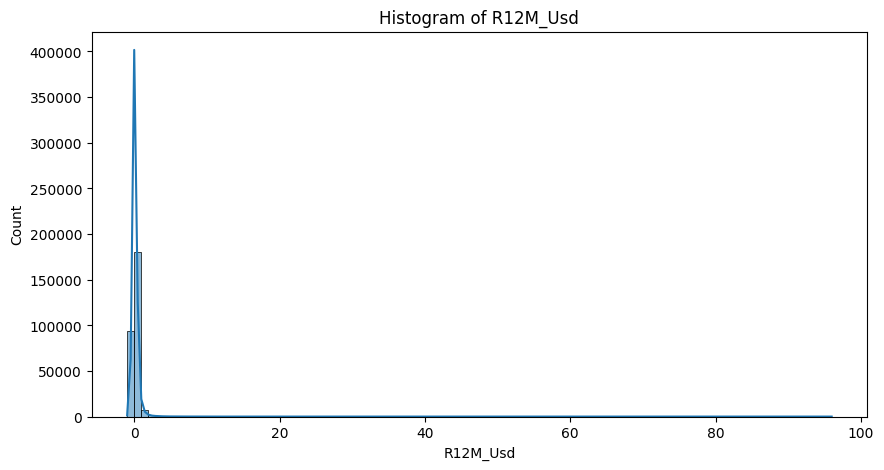

The stock with the highest R12M_Usd value is 683 with a value of 95.972.


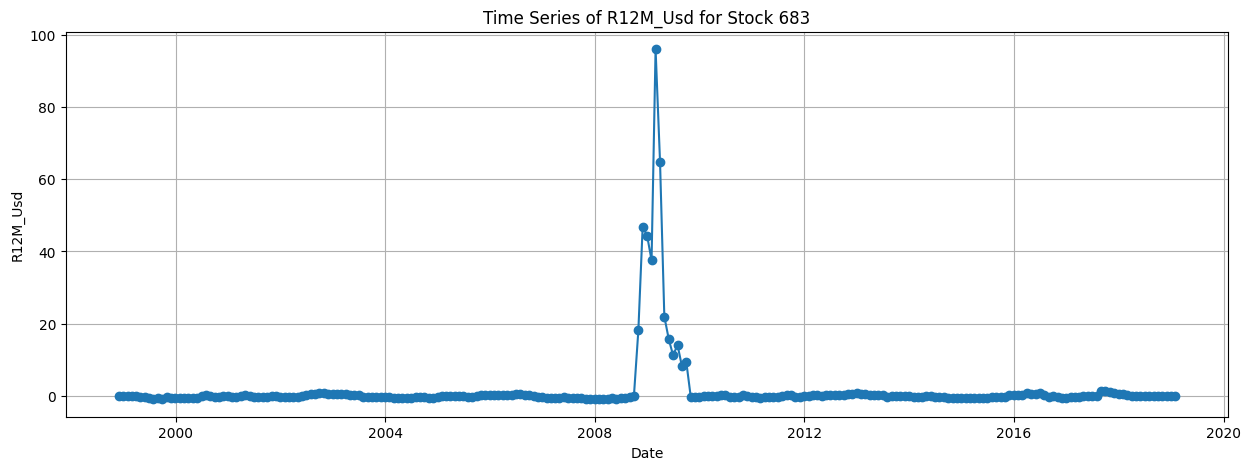

In [13]:
# 3. Plot the histogram of the R12M_Usd variable to dentify the stock with highest value for this variable
plt.figure(figsize=(10,5))
sns.histplot(data_ml['R12M_Usd'], bins=100, kde=True)
plt.title('Histogram of R12M_Usd')
plt.show()
 
max_r12m_value = data_ml['R12M_Usd'].max()
max_r12m_stock = data_ml.loc[data_ml['R12M_Usd'] == max_r12m_value, 'stock_id'].values[0]
print(f"The stock with the highest R12M_Usd value is {max_r12m_stock} with a value of {max_r12m_value}.")

# 4. Plot R12M_Usd time seriesfor this stock
max_r12m_stock_data = data_ml[data_ml['stock_id'] == max_r12m_stock]
plt.figure(figsize=(15,5))
plt.plot(max_r12m_stock_data['date'], max_r12m_stock_data['R12M_Usd'], marker='o')
plt.title(f'Time Series of R12M_Usd for Stock {max_r12m_stock}')
plt.xlabel('Date')
plt.ylabel('R12M_Usd')
plt.grid()
plt.show()


The R12M_Usd of 95.972 is after 2008 (~2009) and is not a single data point, so the value seems correct, it doesn't seem to be an outlier